In [99]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier

In [100]:
# ### Step 1: Selection
# Loading the dataset. Note that this specific dataset usually uses a semicolon ';' separator.

# %%
# Load data
# Make sure 'cardio_train.csv' is in the same folder
try:
    df = pd.read_csv('cardio_train.csv', sep=';')
    print("Data Loaded Successfully!")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print("Error: cardio_train.csv not found. Please download it from Kaggle.")

# Display first few rows
df.head()

Data Loaded Successfully!
Shape: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [101]:
# %% [markdown]
# ### Step 2: Preprocessing
# Cleaning the data, removing duplicates, and filtering impossible outliers.

# %%
# Check for nulls
print(f"Missing values:\n{df.isnull().sum()}")

# Drop 'id' column as it is not needed for prediction
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# --- Outlier Removal ---
# 1. Blood Pressure: Remove cases where Systolic (ap_hi) is lower than Diastolic (ap_lo)
# 2. Blood Pressure: Keep only realistic range (e.g., 50 < ap_hi < 250)
df = df[df['ap_hi'] > df['ap_lo']]
df = df[(df['ap_hi'] > 50) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 30) & (df['ap_lo'] < 150)]

# 3. Height & Weight: Remove extreme outliers
df = df[(df['height'] > 100) & (df['height'] < 250)]
df = df[(df['weight'] > 30) & (df['weight'] < 200)]

print(f"Data Shape after cleaning: {df.shape}")

Missing values:
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64
Data Shape after cleaning: (68600, 12)


In [102]:
# %% [markdown]
# ### Step 3: Transformation
# Feature Engineering and Scaling.

# %%
# --- Feature Engineering ---

# Convert Age from days to years (integer)
df['age_years'] = (df['age'] / 365.25).astype(int)

# Calculate BMI: weight / (height/100)^2
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2

print(df.head())

# Rearrange columns to put target 'cardio' at the end for clarity
# We drop the original 'age' in days to avoid multicollinearity with 'age_years'
features = ['age_years', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
X = df[features]
y = df['cardio']

# Split data FIRST before scaling to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

# --- Scaling ---
# We scale continuous features. Tree models don't strictly need this, but it's good practice.
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

print("Data Transformation complete.")

     age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2     168    62.0    110     80            1     1      0   
1  20228       1     156    85.0    140     90            3     1      0   
2  18857       1     165    64.0    130     70            3     1      0   
3  17623       2     169    82.0    150    100            1     1      0   
4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  age_years        bmi  
0     0       1       0         50  21.967120  
1     0       1       1         55  34.927679  
2     0       0       1         51  23.507805  
3     0       1       1         48  28.710479  
4     0       0       0         47  23.011177  
Data Transformation complete.


In [103]:
# # Define the parameter grid
# param_dist = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [10, 15, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False],
#     'class_weight': ['balanced', 'balanced_subsample', None]
# }
# # Initialize the base model
# rf = RandomForestClassifier(random_state=42)
# # Initialize RandomizedSearchCV
# # n_iter=20 means it will try 20 random combinations
# search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
#                               n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)
# # Fit the search
# print("Starting Hyperparameter Tuning...")
# search.fit(X_train, y_train)
# # Get the best model
# model = search.best_estimator_
# print(f"Model Training Complete. Best Params: {search.best_params_}")

In [104]:
# %% [markdown]
# ### Step 4: Data Mining (Model Training)
# We will use a Random Forest Classifier, which is generally robust for this type of tabular data.

# %%
model = RandomForestClassifier(
    n_estimators=400,
    min_samples_split=12,
    min_samples_leaf=4,
    max_depth=15,
    class_weight='balanced',
    bootstrap=True,
    random_state=56
)




model.fit(X_train, y_train)

print("Model Training Complete.")

Model Training Complete.


Model Accuracy: 73.37%

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6877
           1       0.75      0.69      0.72      6843

    accuracy                           0.73     13720
   macro avg       0.74      0.73      0.73     13720
weighted avg       0.74      0.73      0.73     13720



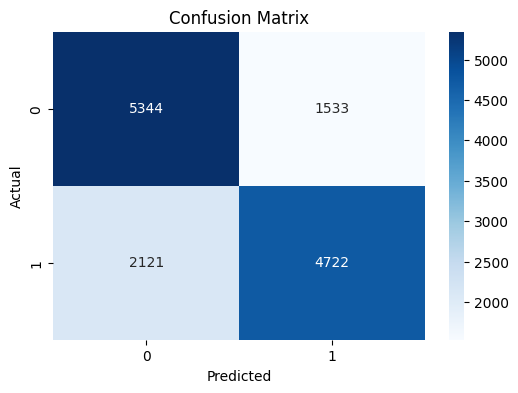

In [105]:
# %% [markdown]
# ### Step 5: Pattern Evaluation
# Checking how well our model performed using Accuracy and a Confusion Matrix.

# %%
# Make predictions
y_pred = model.predict(X_test)

# Calculate Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [106]:
# %% [markdown]
# ### Step 6: User Interface (Backend Preparation)
# We simulate a "Prediction System" and save the model for use in a web app.

# %%
# 1. Save the model and scaler
pickle.dump(model, open('cardio_model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))
print("Model and Scaler saved to disk.")

# 2. Simulation Function (This is the logic your UI would use)
# 2. Simulation Function (FIXED to remove warnings)
def predict_cardio_disease(age_years, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active):
    # Calculate BMI
    bmi = weight / (height / 100) ** 2
    
    # Create input array (DataFrame with names)
    input_data = pd.DataFrame([[age_years, gender, height, weight, bmi, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active]],
                              columns=features)
    
    # Scale input (This turns it into a generic Numpy Array)
    scaled_input_array = scaler.transform(input_data)
    
    # --- THE FIX IS HERE ---
    # Convert the array BACK into a DataFrame with column names
    scaled_input_df = pd.DataFrame(scaled_input_array, columns=features)
    # -----------------------
    
    # Predict using the named DataFrame
    prediction = model.predict(scaled_input_df)[0]
    probability = model.predict_proba(scaled_input_df)[0][1]
    
    return prediction, probability

# --- Test the "Interface" ---
pred, prob = predict_cardio_disease(50, 1, 175, 75, 120, 80, 3, 1, 0, 0, 1)

if pred == 1:
    print(f"\nResult: HIGH RISK of Cardiovascular Disease (Probability: {prob:.2f})")
else:
    print(f"\nResult: Low Risk (Probability: {prob:.2f})")

Model and Scaler saved to disk.

Result: HIGH RISK of Cardiovascular Disease (Probability: 0.66)


In [107]:
# # %% [markdown]
# # # Cardiovascular Disease Prediction - End-to-End Pipeline
# # This notebook covers Selection, Preprocessing, Transformation, Data Mining, Evaluation, and UI Preparation.

# # %%
# # 1. IMPORT LIBRARIES
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import pickle # For saving the model

# # %% [markdown]
# # ### Step 1: Selection
# # Loading the dataset. Note that this specific dataset usually uses a semicolon ';' separator.

# # %%
# # Load data
# # Make sure 'cardio_train.csv' is in the same folder
# try:
#     df = pd.read_csv('cardio_train.csv', sep=';')
#     print("Data Loaded Successfully!")
#     print(f"Shape: {df.shape}")
# except FileNotFoundError:
#     print("Error: cardio_train.csv not found. Please download it from Kaggle.")

# # Display first few rows
# df.head()

# # %% [markdown]
# # ### Step 2: Preprocessing
# # Cleaning the data, removing duplicates, and filtering impossible outliers.

# # %%
# # Check for nulls
# print(f"Missing values:\n{df.isnull().sum()}")

# # Drop 'id' column as it is not needed for prediction
# if 'id' in df.columns:
#     df.drop('id', axis=1, inplace=True)

# # Remove duplicates
# df.drop_duplicates(inplace=True)

# # --- Outlier Removal ---
# # 1. Blood Pressure: Remove cases where Systolic (ap_hi) is lower than Diastolic (ap_lo)
# # 2. Blood Pressure: Keep only realistic range (e.g., 50 < ap_hi < 250)
# df = df[df['ap_hi'] > df['ap_lo']]
# df = df[(df['ap_hi'] > 50) & (df['ap_hi'] < 250)]
# df = df[(df['ap_lo'] > 30) & (df['ap_lo'] < 150)]

# # 3. Height & Weight: Remove extreme outliers
# df = df[(df['height'] > 100) & (df['height'] < 250)]
# df = df[(df['weight'] > 30) & (df['weight'] < 200)]

# print(f"Data Shape after cleaning: {df.shape}")

# # %% [markdown]
# # ### Step 3: Transformation
# # Feature Engineering and Scaling.

# # %%
# # --- Feature Engineering ---

# # Convert Age from days to years (integer)
# df['age_years'] = (df['age'] / 365.25).astype(int)

# # Calculate BMI: weight / (height/100)^2
# df['bmi'] = df['weight'] / (df['height'] / 100) ** 2

# # Rearrange columns to put target 'cardio' at the end for clarity
# # We drop the original 'age' in days to avoid multicollinearity with 'age_years'
# features = ['age_years', 'gender', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
# X = df[features]
# y = df['cardio']

# # Split data FIRST before scaling to prevent data leakage
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # --- Scaling ---
# # We scale continuous features. Tree models don't strictly need this, but it's good practice.
# scaler = StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# print("Data Transformation complete.")

# # %% [markdown]
# # ### Step 4: Data Mining (Model Training)
# # We will use a Random Forest Classifier, which is generally robust for this type of tabular data.

# # %%
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# print("Model Training Complete.")

# # %% [markdown]
# # ### Step 5: Pattern Evaluation
# # Checking how well our model performed using Accuracy and a Confusion Matrix.

# # %%
# # Make predictions
# y_pred = model.predict(X_test)

# # Calculate Accuracy
# acc = accuracy_score(y_test, y_pred)
# print(f"Model Accuracy: {acc * 100:.2f}%")

# # Classification Report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(6,4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # %% [markdown]
# # ### Step 6: User Interface (Backend Preparation)
# # We simulate a "Prediction System" and save the model for use in a web app.

# # %%
# # 1. Save the model and scaler
# pickle.dump(model, open('cardio_model.pkl', 'wb'))
# pickle.dump(scaler, open('scaler.pkl', 'wb'))
# print("Model and Scaler saved to disk.")

# # 2. Simulation Function (This is the logic your UI would use)
# # 2. Simulation Function (FIXED to remove warnings)
# def predict_cardio_disease(age_years, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active):
#     # Calculate BMI
#     bmi = weight / (height / 100) ** 2
    
#     # Create input array (DataFrame with names)
#     input_data = pd.DataFrame([[age_years, gender, height, weight, bmi, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active]],
#                               columns=features)
    
#     # Scale input (This turns it into a generic Numpy Array)
#     scaled_input_array = scaler.transform(input_data)
    
#     # Convert the array BACK into a DataFrame with column names
#     scaled_input_df = pd.DataFrame(scaled_input_array, columns=features)
#     # -----------------------
    
#     # Predict using the named DataFrame
#     prediction = model.predict(scaled_input_df)[0]
#     probability = model.predict_proba(scaled_input_df)[0][1]
    
#     return prediction, probability

# # --- Test the "Interface" ---
# pred, prob = predict_cardio_disease(50, 1, 175, 75, 120, 80, 3, 1, 0, 0, 1)

# if pred == 1:
#     print(f"\nResult: HIGH RISK of Cardiovascular Disease (Probability: {prob:.2f})")
# else:
#     print(f"\nResult: Low Risk (Probability: {prob:.2f})")